In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from data_preprocess import data_preprocess
from feature_extractor import FeatureExtractor
from test_model import test_model

In [2]:
# Load the data and extract gesture segments from the data.
data_path = 'Project_Data_EE4C12_S&S_EMG.csv'
gesture_windows = data_preprocess(data_path)

In [3]:
# Extract features for each gesture
feature_extractor = FeatureExtractor()
features = feature_extractor.extract_features(gesture_windows)

Analyze the class balances using histogram of class samples

0    926
1    144
2    144
3    144
4    144
5    144
6    144
7      8
Name: gesture, dtype: int64


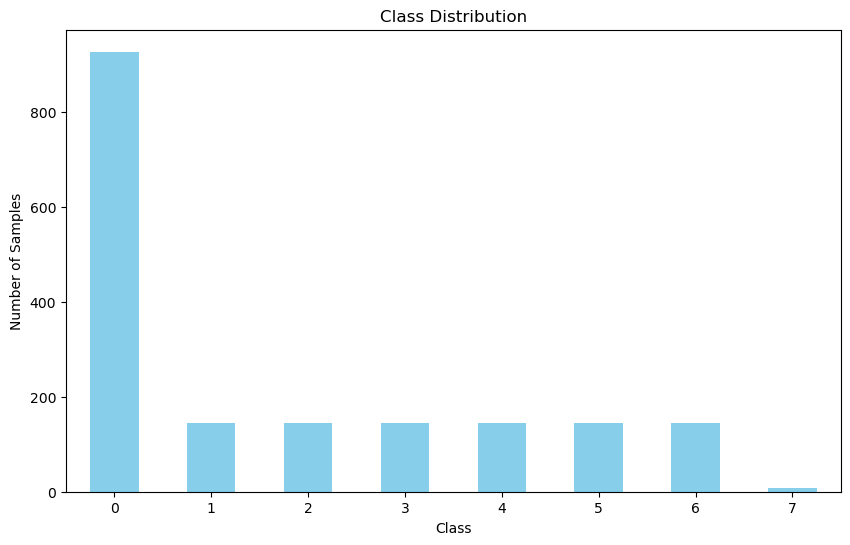

In [4]:
class_balances = features['gesture'].value_counts()
print(class_balances)
plt.figure(figsize=(10, 6))
class_balances.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

It shows that there are too few samples (8 samples) from class 7. We can give that class a higher weight in the loss functions of the future models but even training might not be good enough with this many samples. So we decided to remove the class 7 from the data.

Also, unmarked data belonging to class 0 dominates other classes in terms of number of samples and generally classifiers work better when all classes are balanced. So we can give it a lower weight or subsample the class 0. We chose to subsample the class.

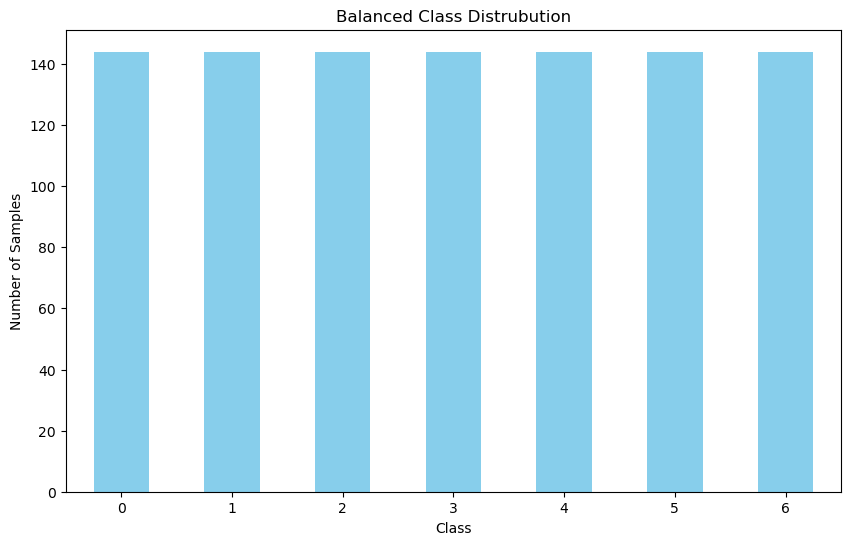

In [5]:
# Remove class 7 from the features dataframe
features_filtered = features[features['gesture'] != 7]

# Get the number of samples for the smallest class (excluding class 0)
min_class_count = features_filtered['gesture'].value_counts().min()

# Subsample class 0 to have the same number of samples as the smallest class
class_0_indices = features_filtered[features_filtered['gesture'] == 0].index
subsampled_class_0_indices = np.random.choice(class_0_indices, min_class_count, replace=False)

# Get the indices of all other classes
other_class_indices = features_filtered[features_filtered['gesture'] != 0].index

# Combine the subsampled class 0 indices with the other class indices
new_indices = np.concatenate([subsampled_class_0_indices, other_class_indices])

# Create the new features dataframe
features_balanced = features_filtered.loc[new_indices]

# Display the class distribution of the new features dataframe
plt.figure(figsize=(10, 6))
features_balanced['gesture'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distrubution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

In [6]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(features_balanced.drop(columns=['gesture']), features_balanced['gesture'], test_size=0.15, random_state=42)

# Reset indices of the resulting datasets
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Create train2-validation split
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

X_train2.reset_index(drop=True, inplace=True)
y_train2.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
y_validation.reset_index(drop=True, inplace=True)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_train shape: {X_train2.shape}")
print(f"y_train shape: {y_train2.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_validation shape: {X_validation.shape}")
print(f"y_validation shape: {y_validation.shape}")


X_train shape: (856, 184)
y_train shape: (856,)
X_train shape: (599, 184)
y_train shape: (599,)
X_test shape: (152, 184)
y_test shape: (152,)
X_validation shape: (257, 184)
y_validation shape: (257,)


In [7]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform other splits
X_test_scaled = scaler.transform(X_test)
X_train2_scaled = scaler.transform(X_train2)
X_validation_scaled = scaler.transform(X_validation)

# Convert the scaled data back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train2_scaled = pd.DataFrame(X_train2_scaled, columns=X_train2.columns)
X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=X_validation.columns)

Find the best C value for the Logistic Regression model based on minimum f1 score of classes on validation set. Then train the best model using whole train set and test it.

In [8]:
C_values = [0.001, 0.01, 0.1, 1, 10]
max_min_f1_score = 0
best_c_value = None
model_params_combinations_lr = []
for c_val in C_values:
    logistic_model = LogisticRegression(C=c_val, max_iter=1000, multi_class="multinomial",
                                        tol=1e-4, random_state=42)

    # Train the model using the scaled training data (not containing validation set samples)
    logistic_model.fit(X_train2_scaled, y_train2)

    # Print the training accuracy
    train_accuracy = logistic_model.score(X_train2_scaled, y_train2)

    # Validate model using the scaled validation data
    metrics = test_model(logistic_model, X_validation_scaled, y_validation)
    print(f"LR model with c={c_val} reached {metrics['min_f1_score']:.2f} minimum f1 score on the validation set.")

    # Save the model parameters and the corresponding metrics
    model_params_combinations_lr.append({
        'c': c_val,
        'min_f1_score': metrics['min_f1_score'],
        'avg_accuracy': metrics['accuracy'],
    })

    if (max_min_f1_score < metrics['min_f1_score']):
        max_min_f1_score = metrics['min_f1_score']
        best_c_value = c_val

model_params_combinations_lr = pd.DataFrame(model_params_combinations_lr)
model_params_combinations_lr.to_csv('model_params_combinations_lr.csv', index=False)

# Train the best model with whole training set
best_model = LogisticRegression(C=best_c_value, max_iter=1000, multi_class="multinomial",
                                tol=1e-4, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Test the best model using the scaled test data
metrics_lr = test_model(best_model, X_test_scaled, y_test, verbose=True, save_file_path="metrics_lr.csv")


LR model with c=0.001 reached 0.57 minimum f1 score on the validation set.
LR model with c=0.01 reached 0.62 minimum f1 score on the validation set.
LR model with c=0.1 reached 0.65 minimum f1 score on the validation set.
LR model with c=1 reached 0.65 minimum f1 score on the validation set.
LR model with c=10 reached 0.65 minimum f1 score on the validation set.
Confusion Matrix:
[[18  1  1  1  0  1  1]
 [ 0 21  0  0  0  0  0]
 [ 0  1 20  1  0  0  1]
 [ 0  2  1 17  0  0  6]
 [ 0  0  0  0 23  1  1]
 [ 0  0  0  1  0 19  0]
 [ 0  0  0  1  0  0 13]]
Accuracy: 0.86
Class 0:
  Precision: 1.0
  Recall: 0.78
  F1 Score: 0.88
Class 1:
  Precision: 0.84
  Recall: 1.0
  F1 Score: 0.91
Class 2:
  Precision: 0.91
  Recall: 0.87
  F1 Score: 0.89
Class 3:
  Precision: 0.81
  Recall: 0.65
  F1 Score: 0.72
Class 4:
  Precision: 1.0
  Recall: 0.92
  F1 Score: 0.96
Class 5:
  Precision: 0.9
  Recall: 0.95
  F1 Score: 0.93
Class 6:
  Precision: 0.59
  Recall: 0.93
  F1 Score: 0.72
Average Precision: 0.86


d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_score

We tune regularization parameter alpha of Ridge Classifier using the validation set. We chose the alpha value with highest minimum f1 score on validation set. Then we trained that model using the whole training set and tested it.

In [9]:
alpha_vals = [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
max_min_f1_score = 0
best_alpha_value = None
model_params_combinations_rc = []
for alpha_val in alpha_vals:
    model = RidgeClassifier(alpha=alpha_val, max_iter=1000,
                                        tol=1e-4, random_state=42)

    # Train the model using the scaled training data (not containing validation set samples)
    model.fit(X_train2_scaled, y_train2)

    # Print the training accuracy
    train_accuracy = model.score(X_train2_scaled, y_train2)

    # Validate model using the scaled validation data
    metrics = test_model(model, X_validation_scaled, y_validation)
    print(f"Ridge Classifier model with alpha={alpha_val} reached {metrics['min_f1_score']:.2f} minimum f1 score on the validation set.")

    model_params_combinations_rc.append({'alpha': alpha_val,
                                        'min_f1_score': metrics['min_f1_score'],
                                        'accuracy': metrics['accuracy']})

    if (max_min_f1_score < metrics['min_f1_score']):
        max_min_f1_score = metrics['min_f1_score']
        best_alpha_value = alpha_val

model_params_combinations_rc = pd.DataFrame(model_params_combinations_rc)
model_params_combinations_rc.to_csv('ridge_classifier_model_params_combinations.csv', index=False)

# Train the best model with whole training set
highest_accuracy_model = RidgeClassifier(alpha=best_alpha_value, max_iter=1000,
                                        tol=1e-4, random_state=42)
highest_accuracy_model.fit(X_train_scaled, y_train)

# Test the best model using the scaled test data
metrics_ridge_classifier = test_model(highest_accuracy_model, X_test_scaled, y_test, verbose=True, save_file_path="metrics_ridge_classifier.csv")

d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_score

Ridge Classifier model with alpha=1e-05 reached 0.57 minimum f1 score on the validation set.
Ridge Classifier model with alpha=0.0001 reached 0.57 minimum f1 score on the validation set.
Ridge Classifier model with alpha=0.001 reached 0.57 minimum f1 score on the validation set.
Ridge Classifier model with alpha=0.01 reached 0.57 minimum f1 score on the validation set.
Ridge Classifier model with alpha=0.1 reached 0.58 minimum f1 score on the validation set.
Ridge Classifier model with alpha=1 reached 0.64 minimum f1 score on the validation set.
Ridge Classifier model with alpha=10 reached 0.63 minimum f1 score on the validation set.
Ridge Classifier model with alpha=100 reached 0.57 minimum f1 score on the validation set.
Ridge Classifier model with alpha=1000 reached 0.56 minimum f1 score on the validation set.
Confusion Matrix:
[[20  1  0  0  0  1  1]
 [ 0 20  0  0  0  1  0]
 [ 0  0 20  2  0  0  1]
 [ 0  2  1 15  0  3  5]
 [ 0  0  0  0 21  4  0]
 [ 0  1  0  0  2 17  0]
 [ 0  0  0  0

Hyperparameters of an MLP are as follows:
1. Number of hidden layers
2. Hidden layer dimensions
3. Activation functions
4. LR scheduling

We tuned LR scheduling using the built-in functionality of MLP using 10% of its training data as a validation set. However, we kept using our own validation set to tune the rest of the hyperparameters using a grid search strategy.

In [10]:
n_hidden_layers = [1, 2, 3, 4]
hidden_layer_sizes = [(100,), (200,), (300,)]
activation_functions = ['relu', 'tanh']
highest_min_f1_score = 0
highest_accuracy_model_params = {}
model_params_combinations = []

for n_layers in n_hidden_layers:
    for layer_size in hidden_layer_sizes:
        for activation in activation_functions:
            layer_size = (layer_size[0],) * n_layers
            mlp_model = MLPClassifier(hidden_layer_sizes=layer_size, max_iter=1000, random_state=42,
                                       activation=activation, learning_rate='adaptive',
                                       learning_rate_init=1e-3, tol=1e-4)

            # Train the model using the scaled training data
            mlp_model.fit(X_train2_scaled, y_train2)
            
            # Validate model using the scaled validation data
            metrics = test_model(mlp_model, X_validation_scaled, y_validation)
            min_f1_score = metrics['min_f1_score']
            print(f"MLP model with {n_layers} hidden layers, {layer_size} neurons, and {activation} activation function reached {min_f1_score:.2f} minimum f1 score on the validation set.")

            model_params_combinations.append({'n_hidden_layers': n_layers,
                                            'hidden_layer_sizes': layer_size,
                                            'activation': activation,
                                            'min_f1_validation': min_f1_score})

            if (highest_min_f1_score < min_f1_score):
                highest_min_f1_score = min_f1_score
                highest_accuracy_model_params['n_hidden_layers'] = n_layers
                highest_accuracy_model_params['hidden_layer_sizes'] = layer_size
                highest_accuracy_model_params['activation'] = activation         

model_params_combinations = pd.DataFrame(model_params_combinations)
model_params_combinations.to_csv('model_params_combinations_mlp.csv', index=False)
print(highest_accuracy_model_params)

# Train the best model using the scaled training data
best_model = MLPClassifier(hidden_layer_sizes=highest_accuracy_model_params['hidden_layer_sizes'],
                            max_iter=1000, random_state=42, activation=highest_accuracy_model_params['activation'],
                              learning_rate='adaptive', learning_rate_init=1e-3, tol=1e-4)

best_model.fit(X_train_scaled, y_train)

# Print the training accuracy
train_accuracy_mlp = best_model.score(X_train_scaled, y_train)

metrics_mlp = test_model(best_model, X_test_scaled, y_test, True, "metrics_mlp.csv")

MLP model with 1 hidden layers, (100,) neurons, and relu activation function reached 0.76 minimum f1 score on the validation set.
MLP model with 1 hidden layers, (100,) neurons, and tanh activation function reached 0.71 minimum f1 score on the validation set.
MLP model with 1 hidden layers, (200,) neurons, and relu activation function reached 0.70 minimum f1 score on the validation set.
MLP model with 1 hidden layers, (200,) neurons, and tanh activation function reached 0.70 minimum f1 score on the validation set.
MLP model with 1 hidden layers, (300,) neurons, and relu activation function reached 0.70 minimum f1 score on the validation set.
MLP model with 1 hidden layers, (300,) neurons, and tanh activation function reached 0.68 minimum f1 score on the validation set.
MLP model with 2 hidden layers, (100, 100) neurons, and relu activation function reached 0.74 minimum f1 score on the validation set.
MLP model with 2 hidden layers, (100, 100) neurons, and tanh activation function reach

d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_score

We also used the validation set to tune hyperparameters of SVC such as inverse regularization parameter (C) and kernel type.

In [19]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
}

# Prepare to store results
results = []

# Perform grid search on the validation set
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        # Train SVM with current hyperparameters on train2 set
        svm_model = SVC(kernel=kernel, C=C, tol=1e-4, random_state=42)
        svm_model.fit(X_train2_scaled, y_train2)

        # Evaluate on validation set
        val_accuracy = svm_model.score(X_validation_scaled, y_validation)

        # Predict on validation set and compute F1 score
        val_predictions = svm_model.predict(X_validation_scaled)
        val_f1_macro = f1_score(y_validation, val_predictions, average='macro')

        # Store hyperparameters and validation results in the results list
        results.append({
            'C': C,
            'kernel': kernel,
            'val_accuracy': val_accuracy,
            'val_f1_macro': val_f1_macro
        })

# Convert results to a DataFrame and find best parameters
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['val_f1_macro'].idxmax()]

# Retrain the best model on the entire train2 set
best_svm = SVC(kernel=best_params['kernel'], C=best_params['C'], tol=1e-4, random_state=42)
best_svm.fit(X_train_scaled, y_train)

# Evaluate the model on the test set (final evaluation)
test_accuracy = best_svm.score(X_test_scaled, y_test)
test_predictions = best_svm.predict(X_test_scaled)
test_f1_macro = f1_score(y_test, test_predictions, average='macro')

best_svm_metrics_non_k_fold = test_model(best_svm, X_test_scaled, y_test, verbose=True, save_file_path="metrics_best_svm_non_k_fold.csv")

# Print the final test results
print(f"Best Hyperparameters: {best_params}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")

# Save the results to CSV
results_df['test_accuracy'] = test_accuracy
results_df['test_f1_macro'] = test_f1_macro
results_df.to_csv('svm_validation_results.csv', index=False)

Confusion Matrix:
[[19  1  0  2  0  0  1]
 [ 1 20  0  0  0  0  0]
 [ 0  0 23  0  0  0  0]
 [ 0  1  1 18  0  1  5]
 [ 0  0  0  0 23  2  0]
 [ 0  0  0  0  1 19  0]
 [ 0  0  0  1  0  0 13]]
Accuracy: 0.89
Class 0:
  Precision: 0.95
  Recall: 0.83
  F1 Score: 0.88
Class 1:
  Precision: 0.91
  Recall: 0.95
  F1 Score: 0.93
Class 2:
  Precision: 0.96
  Recall: 1.0
  F1 Score: 0.98
Class 3:
  Precision: 0.86
  Recall: 0.69
  F1 Score: 0.77
Class 4:
  Precision: 0.96
  Recall: 0.92
  F1 Score: 0.94
Class 5:
  Precision: 0.86
  Recall: 0.95
  F1 Score: 0.9
Class 6:
  Precision: 0.68
  Recall: 0.93
  F1 Score: 0.79
Average Precision: 0.88
Average Recall: 0.9
Average F1 Score: 0.88
Minimum Precision: 0.68
Minimum Recall: 0.69
Minimum F1 Score: 0.77
Class 0 Accuracy: 0.83
Class 1 Accuracy: 0.95
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.69
Class 4 Accuracy: 0.92
Class 5 Accuracy: 0.95
Class 6 Accuracy: 0.93
Best Hyperparameters: C                   10.0
kernel               rbf
val_accuracy    0.85

d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_score

We then tried a more sophisticated method of K-fold validation of SVC. However, we reached the same result as in the 1-fold case. Nevertheless, it increased the reliability of the chosen hyperparameters.

In [20]:
# Initialize K-fold cross-validation (K=5 in this example)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
}

# Prepare to store results
results = []

for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        train_accuracies = []
        validation_accuracies = []
        validation_f1_scores = []
        
        # Perform K-Fold cross-validation
        for train_idx, val_idx in kf.split(X_train_scaled):
            # Split into K-Fold training and validation sets
            X_train_fold, X_val_fold = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Train SVM with current hyperparameters
            svm_model = SVC(kernel=kernel, C=C, tol=1e-4, random_state=42)
            svm_model.fit(X_train_fold, y_train_fold)
            
            # Evaluate on both training and validation sets
            train_accuracy = svm_model.score(X_train_fold, y_train_fold)
            val_accuracy = svm_model.score(X_val_fold, y_val_fold)
            
            # Predict on validation set and compute F1 score
            val_predictions = svm_model.predict(X_val_fold)
            val_f1 = f1_score(y_val_fold, val_predictions, average='macro')
            
            # Store results for this fold
            train_accuracies.append(train_accuracy)
            validation_accuracies.append(val_accuracy)
            validation_f1_scores.append(val_f1)
        
        # Average scores across all folds
        avg_train_accuracy = np.mean(train_accuracies)
        avg_val_accuracy = np.mean(validation_accuracies)
        avg_val_f1_macro = np.mean(validation_f1_scores)
        
        # Store hyperparameters and results in a list
        results.append({
            'C': C,
            'kernel': kernel,
            'avg_train_accuracy': avg_train_accuracy,
            'avg_val_accuracy': avg_val_accuracy,
            'avg_val_f1_macro': avg_val_f1_macro
        })

# Convert results to a DataFrame and find best parameters
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['avg_val_f1_macro'].idxmax()]

# Retrain the best model on the entire training set
best_svm = SVC(kernel=best_params['kernel'], C=best_params['C'], tol=1e-4, random_state=42)
best_svm.fit(X_train_scaled, y_train)

# Evaluate the model on the test set (final evaluation)
test_accuracy = best_svm.score(X_test_scaled, y_test)
test_predictions = best_svm.predict(X_test_scaled)
test_f1_macro = f1_score(y_test, test_predictions, average='macro')
best_svm_metrics = test_model(best_svm, X_test_scaled, y_test, verbose=True, save_file_path="metrics_best_svm.csv")

# Add test results to the DataFrame and save to CSV
results_df['test_accuracy'] = test_accuracy
results_df['test_f1_macro'] = test_f1_macro
results_df.to_csv('svm_kfold_results.csv', index=False)

print(f"Best Hyperparameters: {best_params}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")

Confusion Matrix:
[[19  1  0  2  0  0  1]
 [ 1 20  0  0  0  0  0]
 [ 0  0 23  0  0  0  0]
 [ 0  1  1 18  0  1  5]
 [ 0  0  0  0 23  2  0]
 [ 0  0  0  0  1 19  0]
 [ 0  0  0  1  0  0 13]]
Accuracy: 0.89
Class 0:
  Precision: 0.95
  Recall: 0.83
  F1 Score: 0.88
Class 1:
  Precision: 0.91
  Recall: 0.95
  F1 Score: 0.93
Class 2:
  Precision: 0.96
  Recall: 1.0
  F1 Score: 0.98
Class 3:
  Precision: 0.86
  Recall: 0.69
  F1 Score: 0.77
Class 4:
  Precision: 0.96
  Recall: 0.92
  F1 Score: 0.94
Class 5:
  Precision: 0.86
  Recall: 0.95
  F1 Score: 0.9
Class 6:
  Precision: 0.68
  Recall: 0.93
  F1 Score: 0.79
Average Precision: 0.88
Average Recall: 0.9
Average F1 Score: 0.88
Minimum Precision: 0.68
Minimum Recall: 0.69
Minimum F1 Score: 0.77
Class 0 Accuracy: 0.83
Class 1 Accuracy: 0.95
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.69
Class 4 Accuracy: 0.92
Class 5 Accuracy: 0.95
Class 6 Accuracy: 0.93
Best Hyperparameters: C                         10.0
kernel                     rbf
avg_trai

d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_scores[i], 'accuracy': class_accuracies[i]}, ignore_index=True)
d:\TU Delft\EE4C12\S&S_EMG\EMG-Classification\test_model.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'class': str(i), 'precision': precision[i], 'recall': recall[i], 'f1': f1_score

In [23]:
# Initialize the K-Means model
kmeans_model = KMeans(n_clusters=len(set(y_train)), random_state=42)  # Adjust n_clusters based on your dataset

# Fit the K-Means model using the training data
kmeans_model.fit(X_train2_scaled)

# Predict cluster labels for training, test, and validation datasets
train_clusters = kmeans_model.predict(X_train2_scaled)
test_clusters = kmeans_model.predict(X_test_scaled)
validation_clusters = kmeans_model.predict(X_validation_scaled)

# You can check inertia (within-cluster sum of squares) for evaluating K-Means
print(f"K-Means Inertia: {kmeans_model.inertia_:.4f}")

# Confusion matrix for K-Means (test set)
conf_matrix_kmeans_test = confusion_matrix(y_test, test_clusters)
print("\nK-Means Test Confusion Matrix:\n", conf_matrix_kmeans_test)

# Confusion matrix for K-Means (validation set)
conf_matrix_kmeans_validation = confusion_matrix(y_validation, validation_clusters)
print("\nK-Means Validation Confusion Matrix:\n", conf_matrix_kmeans_validation)

# Calculate the accuracy for K-Means clustering by comparing the clusters with true labels
accuracy_kmeans_train = accuracy_score(y_train2, train_clusters)
accuracy_kmeans_test = accuracy_score(y_test, test_clusters)
accuracy_kmeans_validation = accuracy_score(y_validation, validation_clusters)
metrics_kmeans = test_model(kmeans_model, X_test_scaled, y_test, verbose=True, save_file_path="metrics_kmeans.csv")
print(f"\nK-Means Train Accuracy: {accuracy_kmeans_train:.4f}")
print(f"K-Means Test Accuracy: {accuracy_kmeans_test:.4f}")
print(f"K-Means Validation Accuracy: {accuracy_kmeans_validation:.4f}")

K-Means Inertia: 62328.7426

K-Means Test Confusion Matrix:
 [[ 6 13  1  2  1  0  0]
 [21  0  0  0  0  0  0]
 [ 7  5  8  3  0  0  0]
 [12  2  0 10  2  0  0]
 [ 0  7  0  2  0  0 16]
 [ 2 16  0  0  2  0  0]
 [ 4  1  0  9  0  0  0]]

K-Means Validation Confusion Matrix:
 [[ 7 25  2  6  0  0  0]
 [34  0  0  0  0  0  0]
 [10  6 15  8  2  0  0]
 [14  1  0 14  5  0  0]
 [ 0 13  0  2  0  0 27]
 [ 4 19  0  0  2  0  3]
 [10  0  0 25  2  0  1]]
Confusion Matrix:
[[ 6 13  1  2  1  0  0]
 [21  0  0  0  0  0  0]
 [ 7  5  8  3  0  0  0]
 [12  2  0 10  2  0  0]
 [ 0  7  0  2  0  0 16]
 [ 2 16  0  0  2  0  0]
 [ 4  1  0  9  0  0  0]]
Accuracy: 0.16
Class 0:
  Precision: 0.12
  Recall: 0.26
  F1 Score: 0.16
Class 1:
  Precision: 0.0
  Recall: 0.0
  F1 Score: 0.0
Class 2:
  Precision: 0.89
  Recall: 0.35
  F1 Score: 0.5
Class 3:
  Precision: 0.38
  Recall: 0.38
  F1 Score: 0.38
Class 4:
  Precision: 0.0
  Recall: 0.0
  F1 Score: 0.0
Class 5:
  Precision: 0.0
  Recall: 0.0
  F1 Score: 0.0
Class 6:
  Preci

c:\Users\Aybar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Aybar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Aybar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Aybar\anaconda3\lib\site-packages\sklearn\metr

# Experimentation of SVC with PCA

SVM with PCA (10 components) Training Accuracy: 0.8631
SVM with PCA (10 components) Test Accuracy: 0.8026
SVM with PCA (10 components) Validation Accuracy: 0.7977

SVM with PCA Test Confusion Matrix:
 [[14  2  2  2  0  2  1]
 [ 1 20  0  0  0  0  0]
 [ 0  0 20  1  0  0  2]
 [ 0  1  1 19  0  0  5]
 [ 0  0  0  0 21  4  0]
 [ 0  0  0  1  1 16  2]
 [ 0  0  0  2  0  0 12]]

SVM with PCA Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.61      0.74        23
           1       0.87      0.95      0.91        21
           2       0.87      0.87      0.87        23
           3       0.76      0.73      0.75        26
           4       0.95      0.84      0.89        25
           5       0.73      0.80      0.76        20
           6       0.55      0.86      0.67        14

    accuracy                           0.80       152
   macro avg       0.81      0.81      0.80       152
weighted avg       0.83      0.80      0.80  

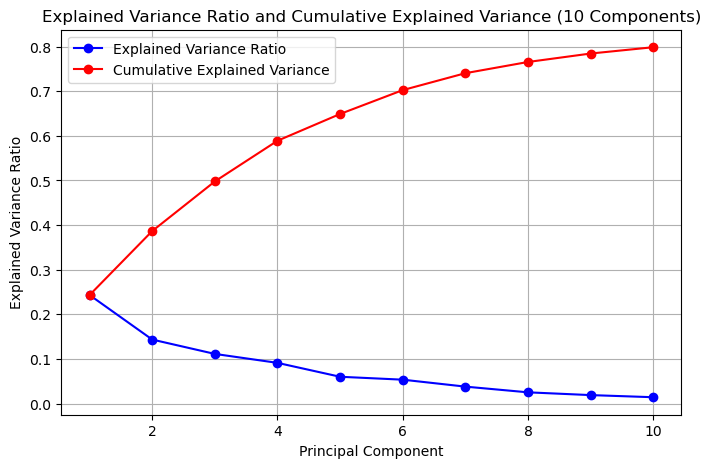

In [22]:
# Apply PCA to reduce the dataset to 10 components
pca_10 = PCA(n_components=10)
X_train2_pca = pca_10.fit_transform(X_train2_scaled)  # Reduce training data
X_test_pca = pca_10.transform(X_test_scaled)        # Apply the same transformation to test data
X_validation_pca = pca_10.transform(X_validation_scaled)  # Apply transformation to validation data

# Train the SVM model using the reduced dataset (10 PCA components)
svm_model_pca = SVC(kernel='linear', C=1, random_state=42)
svm_model_pca.fit(X_train2_pca, y_train2)

# Train the K-Means Clustering model using the reduced dataset (10 PCA components)
kmeans_model_pca = KMeans(n_clusters=len(set(y_train)), random_state=42)  # Number of clusters = number of classes
kmeans_model_pca.fit(X_train2_pca)

# Evaluate the SVM model
# Accuracy on training, test, and validation sets
train_accuracy_pca = svm_model_pca.score(X_train2_pca, y_train2)
test_accuracy_pca = svm_model_pca.score(X_test_pca, y_test)
validation_accuracy_pca = svm_model_pca.score(X_validation_pca, y_validation)

print(f"SVM with PCA (10 components) Training Accuracy: {train_accuracy_pca:.4f}")
print(f"SVM with PCA (10 components) Test Accuracy: {test_accuracy_pca:.4f}")
print(f"SVM with PCA (10 components) Validation Accuracy: {validation_accuracy_pca:.4f}")

# Generate confusion matrix and classification report for the SVM model on test and validation sets
test_predictions_pca = svm_model_pca.predict(X_test_pca)
conf_matrix_pca_test = confusion_matrix(y_test, test_predictions_pca)
class_report_pca_test = classification_report(y_test, test_predictions_pca)

print("\nSVM with PCA Test Confusion Matrix:\n", conf_matrix_pca_test)
print("\nSVM with PCA Test Classification Report:\n", class_report_pca_test)

validation_predictions_pca = svm_model_pca.predict(X_validation_pca)
conf_matrix_pca_validation = confusion_matrix(y_validation, validation_predictions_pca)
class_report_pca_validation = classification_report(y_validation, validation_predictions_pca)

print("\nSVM with PCA Validation Confusion Matrix:\n", conf_matrix_pca_validation)
print("\nSVM with PCA Validation Classification Report:\n", class_report_pca_validation)

# Evaluate K-Means Clustering
# Predict clusters for the test and validation datasets
test_clusters_pca = kmeans_model_pca.predict(X_test_pca)
validation_clusters_pca = kmeans_model_pca.predict(X_validation_pca)

# Confusion matrix for K-Means (test set)
conf_matrix_kmeans_test = confusion_matrix(y_test, test_clusters_pca)
print("\nK-Means with PCA Test Confusion Matrix:\n", conf_matrix_kmeans_test)

# Confusion matrix for K-Means (validation set)
conf_matrix_kmeans_validation = confusion_matrix(y_validation, validation_clusters_pca)
print("\nK-Means with PCA Validation Confusion Matrix:\n", conf_matrix_kmeans_validation)

# Calculate the accuracy for K-Means clustering (by comparing clusters to labels)
accuracy_kmeans_test = accuracy_score(y_test, test_clusters_pca)
accuracy_kmeans_validation = accuracy_score(y_validation, validation_clusters_pca)

print(f"K-Means with PCS Train Accuracy: {accuracy_kmeans_train:.4f}")
print(f"K-Means with PCA Test Accuracy: {accuracy_kmeans_test:.4f}")
print(f"K-Means with PCA Validation Accuracy: {accuracy_kmeans_validation:.4f}")

# Plot the explained variance ratio and cumulative variance (optional)
explained_variance_ratio = pca_10.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), explained_variance_ratio, 'o-', label='Explained Variance Ratio', color='b')
plt.plot(range(1, 11), cumulative_explained_variance, 'o-', label='Cumulative Explained Variance', color='r')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio and Cumulative Explained Variance (10 Components)')
plt.legend()
plt.grid(True)
plt.show()